## Setup

In [ ]:
import os

import warnings
from sklearnex import patch_sklearn
import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.impute import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.kernel_approximation import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from sklearn.covariance import *
from collections import Counter
import sklearn
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import (
    ADASYN,
    SMOTE,
    RandomOverSampler,
    SVMSMOTE,
    SMOTENC,
    SMOTEN,
    BorderlineSMOTE,
    KMeansSMOTE,
)

plt.style.use("fivethirtyeight")

import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory

# patch_sklearn()


def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper


import warnings

warnings.filterwarnings("ignore")

__refresh__ = 1


def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print(
                "Using Cache, Set Refresh to '__refresh__=1' to regenerate "
                "the output of this  function"
            )

    return wrapper


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def categorise_input(X: pd.DataFrame):
    X.loc[:, nominal + ordinal] = X.loc[:, nominal + ordinal].astype("category")
    return X


KAGGLE_ENV = 1
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 1:

    categoriser = FunctionTransformer(
        categorise_input,
    )
categoriser = FunctionTransformer(categorise_input)


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=1000, class_weight="balanced", random_state=42),
    ]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")


def find_correlated_features(df, threshold=0.8):
    correlated_features = set()
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)


"""
PCA MCA Equivalent
"""

# df = raw_data
def MCA(df):
    tmp_nom = np.zeros(df.shape[0])
    for c in df.columns:
        nom_f = df[c]
        nom_f_vc = nom_f.value_counts()
        nom_f_ohe = pd.get_dummies(nom_f)
        nom_f_vc_pk = nom_f_vc / df.shape[0]
        for ci in nom_f_ohe.columns:
            nom_f_ohe[ci] = (nom_f_ohe[ci] / nom_f_vc_pk[ci]) - 1
        tmp_nom = np.c_[tmp_nom, nom_f_ohe.to_numpy()]
        # break
    final_tmp_nom = tmp_nom[:, 1:]
    dime = PCA(
        svd_solver="full",
    )
    final_nome_t = dime.fit_transform(final_tmp_nom)
    return final_nome_t


"""
Binary Target Distributions
"""


def binary_target_dist(df):
    bin_target_0 = pd.DataFrame(columns=binary, index=[0, 1, 2])
    bin_target_1 = pd.DataFrame(columns=binary, index=[0, 1, 2])
    for c in binary:
        target_census = df.target.value_counts().to_dict()
        f = df.groupby([c])["target"].value_counts().sort_index().unstack().transpose()
        # print(f[0])
        bin_target_0[c] = f[0]
        bin_target_1[c] = f[1]
    for i in range(3):
        bin_target_0.loc[i, :] = bin_target_0.loc[i, :] / target_census[i]
        bin_target_1.loc[i, :] = bin_target_1.loc[i, :] / target_census[i]
    return bin_target_0, bin_target_1


def m_VI(df):
    VI = np.linalg.inv(np.cov(df, rowvar=False))
    return VI


class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )
        self.nominal_ohe = None
        self.ordinal_ohe = None

    def add_feature(self, dtype, feature_name):
        dtype_map = {
            "o": self.ordinal_cols,
            "r": self.ratio_cols,
            "b": self.binary_cols,
            "n": self.nominal_cols,
        }
        dtype_map[dtype].append(feature_name)
        return dtype_map[dtype]

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio

    def ordinal_features(self):
        return self.ordinal_cols

    def nominal_features(self):
        return self.nominal_cols

    def binary_features(self):
        return self.binary_cols

    def ratio_features(self):
        return self.ratio_cols

    def update_ohe_features(self, n, o):
        self.nominal_ohe = n
        self.ordinal_ohe = o

    def nominal_ohe_features(self):
        return self.nominal_ohe

    def ordinal_ohe_features(self):
        return self.ordinal_ohe

    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data


column_directory = ColumnSelectors()

DATA_PATH = "/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH = "/kaggle/working/"
TRAIN_DATA = "train.csv"
TEST_DATA = "test.csv"
KAGGLE_ENV = 1
BENCHMARK_INPUT = "/kaggle/input/sub-sample/"
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd or "u164131" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = "../data"
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH = LOCAL_PATH + DATA_SAVE_PATH
    BENCHMARK_INPUT = LOCAL_PATH + BENCHMARK_INPUT

CACHE_ = Memory(DATA_SAVE_PATH, verbose=0)


def write_raw_data(raw_data: pd.DataFrame, raw_data_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


def write_raw_data_ohe(raw_data_ohe: pd.DataFrame, raw_data_ohe_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data_ohe.to_parquet(DATA_SAVE_PATH + "train_ohe.parquet")
    raw_data_ohe_eval.to_parquet(DATA_SAVE_PATH + "test_ohe.parquet")


# TODO rerun this script to rename the target column


def reload_raw_data():
    global DATA_SAVE_PATH
    raw_data = pd.read_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval


def reload_raw_data_ohe():
    global DATA_SAVE_PATH
    raw_data_ohe = pd.read_parquet(DATA_SAVE_PATH + "train_ohe.parquet")
    raw_data_ohe_eval = pd.read_parquet(DATA_SAVE_PATH + "test_ohe.parquet")
    return raw_data_ohe, raw_data_ohe_eval


benchmark = pd.read_csv(BENCHMARK_INPUT + "sample.csv")


def make_submission(y):
    trial = 0
    y_df = pd.DataFrame(y, columns=["label"])
    y_df.index.rename("id", inplace=True)
    y_df.to_csv(
        DATA_SAVE_PATH + "submission.csv",
    )
    if trial == 0:
        benchmark.to_csv(DATA_SAVE_PATH + "submission.csv")


def rename_columns_with_dtype(
    DATA_PATH=DATA_PATH, DATA_SAVE_PATH=DATA_SAVE_PATH, clear_history=True
):
    """
    Set clear_history to False
    """
    initial_column_directory = ColumnSelectors()
    train_data = pd.read_csv(DATA_PATH + TRAIN_DATA, index_col=0)
    test_data = pd.read_csv(DATA_PATH + TEST_DATA, index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = initial_column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split("__")
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    train_data.rename(columns=raw_dtypes_info, inplace=True)
    test_data.rename(columns=raw_dtypes_info, inplace=True)
    train_data.rename(columns={"label": "target"}, inplace=True)
    if clear_history:
        write_raw_data(train_data, test_data)
    return train_data, test_data


# rename_columns_with_dtype()
def reset_data(remove_cache=True):
    return rename_columns_with_dtype(clear_history=remove_cache)


raw_data, raw_data_eval = reset_data()

X = raw_data.drop(["target"], axis=1)
y = raw_data.target
import copy

ordinal = column_directory.ordinal_features()
nominal = column_directory.nominal_features()
binary = column_directory.binary_features()
ratios = column_directory.ratio_features()
discrete_binary = copy.deepcopy(binary)
discrete_ordinal = copy.deepcopy(ordinal)
ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

raw_data, raw_data_eval = reset_data()


def gen_categorical_mask(df):
    categorical_f_mask = []
    for f in df.columns:
        if f in ordinal + nominal + binary:
            categorical_f_mask.append(True)
        else:
            categorical_f_mask.append(False)
    return categorical_f_mask


def update_ordinal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    categorical_columns = [ordinal, nominal]
    ordinal_data = raw_data.loc[:, ordinal].copy()
    ordinal_data_eval = raw_data_eval.loc[:, ordinal].copy()
    raw_data.loc[:, ordinal] = ordinal_data - ordinal_data.min()
    raw_data_eval.loc[:, ordinal] = ordinal_data_eval - ordinal_data.min()
    return raw_data, raw_data_eval


def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    return raw_data, raw_data_eval


# @run_if_refresh
def ordinally_encode_nominal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    X_master = pd.concat(
        [raw_data.loc[:, raw_data_eval.columns], raw_data_eval],
        ignore_index=True,
        axis=0,
    )
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=125)
    ordinal_enc.fit(X_master.loc[:, nominal])
    nominal_enc_data = ordinal_enc.transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    return raw_data, raw_data_eval


# @run_if_refresh
def binary_feature_sum(raw_data=raw_data, raw_data_eval=raw_data_eval):
    global column_directory
    raw_data["binary__sum"] = raw_data.loc[:, binary].sum(axis=1) / 8
    raw_data_eval["binary__sum"] = raw_data_eval.loc[:, binary].sum(axis=1) / 8
    column_directory.add_feature("b", "binary__sum")
    return raw_data, raw_data_eval


# @run_if_refresh
def standardise_ratio_features(
    raw_data=raw_data.copy(), raw_data_eval=raw_data_eval.copy()
):
    # Load Data
    payload = raw_data.loc[:, ratios]
    payload_eval = raw_data_eval.loc[:, ratios]
    mscaler = Normalizer()
    # Apply Scaling
    payload_t = mscaler.fit_transform(payload)
    payload_eval_t = mscaler.transform(payload_eval)
    # Create Dataframe with new features to concatenate
    tmp_raw_data = pd.DataFrame(payload_t, columns=ratios, index=raw_data.index)
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=ratios, index=raw_data_eval.index
    )
    # Update in place
    raw_data.loc[:, ratios] = tmp_raw_data
    raw_data_eval.loc[:, ratios] = tmp_raw_data_eval
    # Write modified data to disk
    return raw_data, raw_data_eval


def ordinal_norm(df):
    scaler = PowerTransformer()
    tmp_ord = df.loc[:, ordinal].to_numpy()
    tmp_ord_sq = tmp_ord @ tmp_ord.T
    tmp_ord_sum = np.sqrt(tmp_ord_sq.sum(axis=1))
    tmp_ord_nom = scaler.fit_transform(tmp_ord_sum.reshape(-1, 1))
    return tmp_ord_nom


"""
Making Categories Similar within Training Data and Test Data
"""


def cleanup_feature_names(ct):
    f_names = []
    fd = ct.get_feature_names_out()
    for c in fd:
        st = c.split("__")
        e = c.replace(st[0] + "__", "")
        f_names.append(e)
    return f_names


enc = OneHotEncoder(
    sparse=False,
)
num_enc = Normalizer()
num_f = np.setdiff1d(
    raw_data_eval.columns, nominal + discrete_ordinal + discrete_binary
)
ct = make_column_transformer(
    (enc, nominal + discrete_ordinal),
    ("passthrough", discrete_binary),
    sparse_threshold=0,
    n_jobs=-1,
)
comb_ct = make_column_transformer(
    (enc, nominal + discrete_ordinal),
    ("passthrough", discrete_binary),
    (num_enc, num_f),
    sparse_threshold=0,
    n_jobs=-1,
)
X_master = pd.concat(
    [raw_data.loc[:, raw_data_eval.columns], raw_data_eval], ignore_index=True, axis=0
)

ct.fit(X_master.loc[:, nominal + discrete_ordinal + discrete_binary])
comb_ct.fit(X_master)
Tx = comb_ct.transform(raw_data)
Tx_ = comb_ct.transform(raw_data_eval)
f_names = cleanup_feature_names(ct)
X = pd.DataFrame(ct.transform(raw_data), columns=f_names)
X_ = pd.DataFrame(ct.transform(raw_data_eval), columns=f_names)
d_metrics = [
    "matching",
    "jaccard",
    "dice",
    "kulsinski",
    "rogerstanimoto",
    "russellrao",
    "sokalmichener",
    "sokalsneath",
    "hamming",
]
d_num_metrics = [
    "braycurtis",
    "canberra",
    "chebyshev",
    "cityblock",
    "euclidean",
    "l1",
    "l2",
    "manhattan",
    "minkowski",
    "p",
]


def counterpart_eval(li_idx, c):
    return raw_data_eval.loc[li_idx, c]


def counterpart_train(li_idx, c):
    return raw_data.loc[li_idx, c]


def link_outlier_categories_train(raw_data, raw_data_eval):
    ufo_val = {}
    ufo_val_idx = {x: {} for x in nominal + discrete_ordinal}
    u_i = []
    ufo_idx = None
    for c in nominal + discrete_ordinal:
        i_ = raw_data[c].unique()
        i__ = raw_data_eval[c].unique()
        ufo = np.setdiff1d(i_, i__)
        ufo_val[c] = list(ufo)
        if len(ufo) > 0:
            #         tmp = raw_data[raw_data[c]==list(ufo)[0]].index
            for val in list(ufo):
                ufo_val_idx[c][val] = raw_data[raw_data[c] == val].index

    ufo_val_idx_ = copy.deepcopy(ufo_val_idx)
    for i in ufo_val_idx:
        if len(ufo_val_idx[i].keys()) == 0:
            del ufo_val_idx_[i]
    # import pprint
    # pprint.pprint(ufo_val_idx_)
    ufo_idx = []
    for c in ufo_val_idx_:
        for k in ufo_val_idx_[c]:
            ufo_idx.extend(list(ufo_val_idx_[c][k]))
    ufo_idx = list(set(ufo_idx))
    len(ufo_idx)

    trees_categ = [BallTree(X_, leaf_size=1, metric=d_m) for d_m in d_metrics]
    tree_comb = [BallTree(Tx_, leaf_size=1, metric=d_m) for d_m in d_num_metrics]
    # trees_num =

    cat_n_idx = []
    comb_n_idx = []
    for tree in trees_categ:
        d, idx = tree.query(X.loc[ufo_idx, :], k=1)
        cat_n_idx.append(idx.ravel())

    for tree in tree_comb:
        d, idx = tree.query(Tx[ufo_idx, :], k=1)
        comb_n_idx.append(idx.ravel())

    cat_N = pd.DataFrame(index=ufo_idx)
    for i in range(len(d_metrics)):
        cat_N[i] = cat_n_idx[i]

    for i in range(len(d_num_metrics)):
        cat_N["comb__" + str(i)] = comb_n_idx[i]

    cat_N["mde"] = cat_N.mode(axis=1)[0]

    cat_N["mde"] = cat_N["mde"].astype("int")

    ufo_val_cpart = {x: {} for x in nominal + discrete_ordinal}
    for c in ufo_val_idx_:
        uf_subs = {}

        for val in ufo_val_idx_[c]:
            uf_ids = list(ufo_val_idx_[c][val])
            for u_id in uf_ids:
                # uf_subs.append()
                uf_subs[u_id] = counterpart_eval(cat_N["mde"].loc[u_id], c)
        ufo_val_cpart[c] = uf_subs
    # ufo_val_cpart
    raw_data_ufo = raw_data.loc[:, nominal + discrete_ordinal].copy()
    for c in ufo_val_cpart:
        for k, v in ufo_val_cpart[c].items():
            raw_data_ufo.loc[k, c] = v
    raw_data_ufo_train = raw_data_ufo
    return raw_data_ufo_train


def link_outlier_categories_eval(raw_data, raw_data_eval):
    ufo_val = {}
    ufo_val_idx = {x: {} for x in nominal + discrete_ordinal}
    u_i = []
    ufo_idx = None
    for c in nominal + discrete_ordinal:
        i_ = raw_data[c].unique()
        i__ = raw_data_eval[c].unique()
        ufo = np.setdiff1d(i__, i_)
        ufo_val[c] = list(ufo)
        if len(ufo) > 0:
            #         tmp = raw_data[raw_data[c]==list(ufo)[0]].index
            for val in list(ufo):
                ufo_val_idx[c][val] = raw_data_eval[raw_data_eval[c] == val].index

    ufo_val_idx_ = copy.deepcopy(ufo_val_idx)
    for i in ufo_val_idx:
        if len(ufo_val_idx[i].keys()) == 0:
            del ufo_val_idx_[i]
    # import pprint
    # pprint.pprint(ufo_val_idx_)
    ufo_idx = []
    for c in ufo_val_idx_:
        for k in ufo_val_idx_[c]:
            ufo_idx.extend(list(ufo_val_idx_[c][k]))
    ufo_idx = list(set(ufo_idx))
    trees_categ = [BallTree(X, leaf_size=1, metric=d_m) for d_m in d_metrics]
    tree_comb = [BallTree(Tx, leaf_size=1, metric=d_m) for d_m in d_num_metrics]
    # trees_num =

    cat_n_idx = []
    comb_n_idx = []
    for tree in trees_categ:
        d, idx = tree.query(X_.loc[ufo_idx, :], k=1)
        cat_n_idx.append(idx.ravel())

    for tree in tree_comb:
        d, idx = tree.query(Tx_[ufo_idx, :], k=1)
        comb_n_idx.append(idx.ravel())

    cat_N = pd.DataFrame(index=ufo_idx)
    for i in range(len(d_metrics)):
        cat_N[i] = cat_n_idx[i]

    for i in range(len(d_num_metrics)):
        cat_N["comb__" + str(i)] = comb_n_idx[i]

    cat_N["mde"] = cat_N.mode(axis=1)[0]

    cat_N["mde"] = cat_N["mde"].astype("int")
    ufo_val_cpart = {x: {} for x in nominal + discrete_ordinal}
    for c in ufo_val_idx_:
        uf_subs = {}

        for val in ufo_val_idx_[c]:
            uf_ids = list(ufo_val_idx_[c][val])
            for u_id in uf_ids:
                # uf_subs.append()
                uf_subs[u_id] = counterpart_train(cat_N["mde"].loc[u_id], c)
        ufo_val_cpart[c] = uf_subs

    # ufo_val_cpart
    raw_data_ufo = raw_data_eval.loc[:, nominal + discrete_ordinal].copy()
    for c in ufo_val_cpart:
        for k, v in ufo_val_cpart[c].items():
            raw_data_ufo.loc[k, c] = v
    raw_data_ufo_eval = raw_data_ufo
    return raw_data_ufo_eval


compactor = defaultdict(list)


def compact_categories(raw_data, raw_data_eval):
    def get_protected_by_feature():
        discrete = nominal + discrete_ordinal
        X = raw_data.copy()
        # spec1 = X[(X["target"] != 2)][discrete]
        unq_f = {c: {} for c in discrete}
        partitions = [X[(X["target"] == i)][discrete] for i in range(3)]

        cmn_f = {c: [] for c in discrete}
        for c in discrete:
            p_uniq = [p[c].unique() for p in partitions]
            cmmn = np.intersect1d(p_uniq[0], p_uniq[1])
            cmmn = np.intersect1d(cmmn, p_uniq[2])
            cmn_f[c] = cmmn

        unq_f = {c: {} for c in discrete}

        for c in discrete:
            t_uniq = [p[c].unique() for p in partitions]
            # A - A ∩ (B U C)
            targets = [0, 1, 2]
            other_union = [np.array([]) for i in range(3)]

            for i in range(3):
                for j in range(3):
                    if i == j:
                        continue
                    else:
                        other_union[i] = np.union1d(other_union[i], t_uniq[j])
            intersects = [np.intersect1d(t_uniq[i], other_union[i]) for i in range(3)]
            spec_uniq = [np.setdiff1d(t_uniq[i], intersects[i]) for i in range(3)]
            unq_f[c] = {i: spec_uniq[i] for i in range(3)}
        #     unq_f = {k:v for k,v in unq_f.items() if len(v.keys())>0}
        protected = {c: [] for c in nominal + discrete_ordinal}
        for c in unq_f:
            protected[c] = np.array([])
            for v in unq_f[c].values():
                protected[c] = np.union1d(protected[c], v).astype("int")
        return protected

    protected = get_protected_by_feature()

    def compact_nominal(threshold):
        global compactor
        X = raw_data.copy()
        tmp_ = X[X["target"] != 2]
        #     minority = X[X["target"] == 2]
        for c in nominal:
            vc = tmp_[c].value_counts().sort_values(ascending=False)
            cum_vc = vc.cumsum(axis=0)
            consolid = cum_vc[cum_vc > threshold * tmp_.shape[0]].index
            consolid = [val for val in consolid if val not in protected[c]]
            compactor[c] = list(consolid)

    def compact_ordinal(threshold):
        global compactor
        X = raw_data.copy()
        tmp_ = X[X["target"] != 2]
        #     minority = X[X["target"] == 2]
        for c in discrete_ordinal:
            vc = tmp_[c].value_counts().sort_values(ascending=False)
            cum_vc = vc.cumsum(axis=0)
            consolid = cum_vc[cum_vc > threshold * tmp_.shape[0]].index
            consolid = [val for val in consolid if val not in protected[c]]
            compactor[c] = list(consolid)

    def compact_discrete(row):
        global compactor
        for c in compactor:
            if row[c] in compactor[c]:
                row[c] = int(np.mean(compactor[c]))
        return row

    X = raw_data.copy()
    compact_nominal(0.95)
    X_eval = raw_data_eval.copy()
    X = X.apply(compact_discrete, axis=1)
    X_eval = X_eval.apply(compact_discrete, axis=1)
    return X, X_eval


def gen_ordinal__norm(raw_data=raw_data, raw_data_eval=raw_data_eval):
    global column_directory
    raw_data["ordinal__norm"] = ordinal_norm(raw_data)
    raw_data_eval["ordinal__norm"] = ordinal_norm(raw_data_eval)
    column_directory.add_feature("o", "ordinal__norm")
    return raw_data, raw_data_eval


def gen_ohe_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    global column_directory
    least_frequent_categories = {
        "nominal__v_12": 33,
        "nominal__v_18": 79,
        "nominal__v_20": 61,
        "nominal__v_21": 18,
        "nominal__v_25": 25,
        "nominal__v_3": 117,
        "nominal__v_32": 77,
        "nominal__v_4": 1,
        "ordinal__v_0": 25,
        "ordinal__v_10": 40,
        "ordinal__v_13": 38,
        "ordinal__v_15": 9,
        "ordinal__v_17": 72,
        "ordinal__v_19": 45,
        "ordinal__v_22": 38,
        "ordinal__v_23": 17,
        "ordinal__v_24": 37,
        "ordinal__v_29": 31,
        "ordinal__v_31": 70,
        "ordinal__v_33": 45,
        "ordinal__v_5": 63,
        "ordinal__v_6": 30,
    }
    drop_mask = np.array([least_frequent_categories[x] for x in nominal + ordinal])
    X = pd.concat(
        [raw_data.loc[:, raw_data_eval.columns], raw_data_eval],
        ignore_index=True,
        axis=0,
    )
    ohe = OneHotEncoder(sparse=False, dtype=np.int8)
    ohe.fit(X.loc[:, nominal + ordinal])
    nominal_ohe = [x for x in ohe.get_feature_names_out() if "nominal__" in x]
    ordinal_ohe = [x for x in ohe.get_feature_names_out() if "ordinal__" in x]
    ohe_data = pd.DataFrame(
        ohe.transform(raw_data.loc[:, nominal + ordinal]),
        columns=ohe.get_feature_names_out(),
        index=raw_data.index,
    )
    ohe_data_eval = pd.DataFrame(
        ohe.transform(raw_data_eval.loc[:, nominal + ordinal]),
        columns=ohe.get_feature_names_out(),
        index=raw_data_eval.index,
    )
    other_than_nominal = [x for x in raw_data_eval.columns if "nominal__" not in x]
    raw_data_ohe = pd.concat([ohe_data, raw_data.loc[:, other_than_nominal]], axis=1)
    raw_data_ohe_eval = pd.concat(
        [ohe_data_eval, raw_data_eval.loc[:, other_than_nominal]], axis=1
    )
    column_directory.update_ohe_features(nominal_ohe, ordinal_ohe)
    return raw_data_ohe, raw_data_ohe_eval


def gen_binary_literal(row):
    bin_chr = [str(row[b]) for b in binary if "sum" not in b]
    b_l = ""
    for c in bin_chr:
        b_l += c
    row.binary__literal = int(b_l, 2) / 255
    return row


def add_literal_to_data(raw_data, raw_data_eval):
    global column_directory
    b_lit_train = pd.DataFrame(columns=["binary__literal"], index=raw_data.index)
    b_lit_eval = pd.DataFrame(columns=["binary__literal"], index=raw_data_eval.index)
    raw_data["binary__literal"] = "0"
    raw_data_eval["binary__literal"] = "0"
    raw_data = raw_data.apply(gen_binary_literal, axis=1)
    raw_data_eval = raw_data_eval.apply(gen_binary_literal, axis=1)
    column_directory.add_feature("b", "binary__literal")
    return raw_data, raw_data_eval


def standardise_ordinal_data(raw_data, raw_data_eval, raw_data_ohe, raw_data_ohe_eval):
    scaler = sklearn.preprocessing.Normalizer()
    scaler.fit(X_master.loc[:, ordinal])
    ordinal_data = pd.DataFrame(
        scaler.transform(raw_data.loc[:, ordinal]),
        columns=ordinal,
        index=raw_data.index,
    )
    ordinal_data_eval = pd.DataFrame(
        scaler.transform(raw_data_eval.loc[:, ordinal]),
        columns=ordinal,
        index=raw_data_eval.index,
    )

    #     raw_data.loc[:,ordinal] = ordinal_data
    raw_data_ohe.loc[:, ordinal] = ordinal_data
    #     raw_data_eval.loc[:,ordinal] = ordinal_data_eval
    raw_data_ohe_eval.loc[:, ordinal] = ordinal_data_eval
    return raw_data, raw_data_eval, raw_data_ohe, raw_data_ohe_eval


def make_int_nominal(df):
    global column_directory
    nominal = column_directory.nominal_features()
    df.loc[:, nominal] = df.loc[:, nominal].astype("int")
    return df


def apply_transformations():
    global X_master
    raw_data, raw_data_eval = reset_data(remove_cache=True)

    raw_data = make_int_nominal(raw_data)
    raw_data_eval = make_int_nominal(raw_data_eval)

    raw_data, raw_data_eval = binary_feature_sum(raw_data, raw_data_eval)

    raw_data, raw_data_eval = standardise_ratio_features(raw_data, raw_data_eval)

    raw_data, raw_data_eval = add_literal_to_data(raw_data, raw_data_eval)
    raw_data.loc[:, nominal + discrete_ordinal] = link_outlier_categories_train(
        raw_data, raw_data_eval
    )
    raw_data_eval.loc[:, nominal + discrete_ordinal] = link_outlier_categories_eval(
        raw_data, raw_data_eval
    )
    raw_data, raw_data_eval = compact_categories(raw_data, raw_data_eval)
    raw_data, raw_data_eval = ordinally_encode_nominal_data(raw_data, raw_data_eval)
    raw_data = make_int_nominal(raw_data)
    raw_data_eval = make_int_nominal(raw_data_eval)
    raw_data_ohe, raw_data_ohe_eval = gen_ohe_data(raw_data, raw_data_eval)

    raw_data, raw_data_eval = update_ordinal_data(raw_data, raw_data_eval)

    raw_data, raw_data_eval, raw_data_ohe, raw_data_ohe_eval = standardise_ordinal_data(
        raw_data, raw_data_eval, raw_data_ohe, raw_data_ohe_eval
    )

    raw_data, raw_data_eval = gen_ordinal__norm(raw_data, raw_data_eval)

    raw_data_ohe["ordinal__norm"] = raw_data["ordinal__norm"]

    raw_data_ohe_eval["ordinal__norm"] = raw_data_eval["ordinal__norm"]
    write_raw_data(raw_data, raw_data_eval)
    write_raw_data_ohe(raw_data_ohe, raw_data_ohe_eval)
    X_master = pd.concat(
        [raw_data.loc[:, raw_data_eval.columns], raw_data_eval],
        ignore_index=True,
        axis=0,
    )


apply_transformations()
raw_data, raw_data_eval = reload_raw_data()

raw_data_ohe, raw_data_ohe_eval = reload_raw_data_ohe()


def refresh_data():
    global __refresh__
    __refresh__ = 1
    raw_data, raw_data_eval = reset_data()
    # rename_columns_with_dtype()
    apply_transformations()
    raw_data, raw_data_eval = reload_raw_data()
    __refresh__ = 0
    print("Data Refresh Success")
    return raw_data, raw_data_eval


# raw_data, raw_data_eval = refresh_data()

features = raw_data.drop(["target"], axis=1).columns


def create_target_encoding():
    new_column_names = []
    stubs = ["_0", "_1", "_2"]
    for c in ordinal + nominal:
        for _suffix in stubs:
            new_column_names.append(c + _suffix)
    df_train = pd.DataFrame(index=raw_data.index, columns=new_column_names)
    df_eval = pd.DataFrame(index=raw_data_eval.index, columns=new_column_names)
    target_census = raw_data.target.value_counts().to_dict()
    for c in ordinal + nominal:
        target_counts = (
            raw_data.groupby(c)["target"].value_counts().unstack(fill_value=0)
        )
        tf: pd.DataFrame = target_counts.loc[:, [0, 1, 2]]
        target_counts["sum"] = tf.sum(axis=1)
        target_counts["std"] = tf.std(axis=1)
        tf2 = tf.divide((target_counts["sum"]), axis="rows")
        target_map = {0: 0, 1: 1, 2: 2}
        for val in target_map:
            mapping = defaultdict(int, tf2.to_dict()[target_map[val]])
            df_train[c + stubs[val]] = raw_data[c].map(mapping)
            df_eval[c + stubs[val]] = raw_data_eval[c].map(mapping)
    return df_train, df_eval


target_encoded_train, target_encoded_eval = create_target_encoding()

"""
Refreshing Data Bifurication
"""

ordinal = column_directory.ordinal_features()
nominal = column_directory.nominal_features()
binary = column_directory.binary_features()
ratios = column_directory.ratio_features()
nominal_ohe = column_directory.nominal_ohe_features()
ordinal_ohe = column_directory.ordinal_ohe_features()
ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)
original_ordinal_data, original_ordinal_data_eval = reset_data(remove_cache=False)
o_f = [x for x in original_ordinal_data.columns if "ordinal" in x]
old_ordinal = original_ordinal_data.loc[:, o_f]
old_ordinal_eval = original_ordinal_data_eval.loc[:, o_f]

In [ ]:
"""Stacking classifier and regressor."""

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

from abc import ABCMeta, abstractmethod
from copy import deepcopy

import numpy as np
from joblib import Parallel
import scipy.sparse as sparse

from sklearn.base import clone
from sklearn.base import ClassifierMixin, RegressorMixin, TransformerMixin
from sklearn.base import is_classifier, is_regressor
from sklearn.exceptions import NotFittedError
from sklearn.utils._estimator_html_repr import _VisualBlock

from sklearn.ensemble._base import _fit_single_estimator
from sklearn.ensemble._base import _BaseHeterogeneousEnsemble

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import check_cv

from sklearn.preprocessing import LabelEncoder

from sklearn.utils import Bunch
from sklearn.utils.metaestimators import available_if
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_scalar
from sklearn.utils.validation import column_or_1d
from sklearn.utils.fixes import delayed
from sklearn.utils.validation import _check_feature_names_in


def _estimator_has(attr):
    """Check if we can delegate a method to the underlying estimator.
    First, we check the first fitted final estimator if available, otherwise we
    check the unfitted final estimator.
    """
    return lambda self: (
        hasattr(self.final_estimator_, attr)
        if hasattr(self, "final_estimator_")
        else hasattr(self.final_estimator, attr)
    )


class _BaseStacking(TransformerMixin, _BaseHeterogeneousEnsemble, metaclass=ABCMeta):
    """Base class for stacking method."""

    @abstractmethod
    def __init__(
        self,
        estimators,
        final_estimator=None,
        *,
        cv=None,
        stack_method="auto",
        n_jobs=None,
        verbose=0,
        passthrough=False,
    ):
        super().__init__(estimators=estimators)
        self.final_estimator = final_estimator
        self.cv = cv
        self.stack_method = stack_method
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.passthrough = passthrough

    def _clone_final_estimator(self, default):
        if self.final_estimator is not None:
            self.final_estimator_ = clone(self.final_estimator)
        else:
            self.final_estimator_ = clone(default)

    def _concatenate_predictions(self, X, predictions):
        """Concatenate the predictions of each first layer learner and
        possibly the input dataset `X`.
        If `X` is sparse and `self.passthrough` is False, the output of
        `transform` will be dense (the predictions). If `X` is sparse
        and `self.passthrough` is True, the output of `transform` will
        be sparse.
        This helper is in charge of ensuring the predictions are 2D arrays and
        it will drop one of the probability column when using probabilities
        in the binary case. Indeed, the p(y|c=0) = 1 - p(y|c=1)
        """
        X_meta = []
        for est_idx, preds in enumerate(predictions):
            # case where the estimator returned a 1D array
            if preds.ndim == 1:
                X_meta.append(preds.reshape(-1, 1))
            else:
                if (
                    self.stack_method_[est_idx] == "predict_proba"
                    and len(self.classes_) == 2
                ):
                    # Remove the first column when using probabilities in
                    # binary classification because both features are perfectly
                    # collinear.
                    X_meta.append(preds[:, 1:])
                else:
                    X_meta.append(preds)

        self._n_feature_outs = [pred.shape[1] for pred in X_meta]
        if self.passthrough:
            X_meta.append(X)
            if sparse.issparse(X):
                return sparse.hstack(X_meta, format=X.format)

        return np.hstack(X_meta)

    @staticmethod
    def _method_name(name, estimator, method):
        if estimator == "drop":
            return None
        if method == "auto":
            if getattr(estimator, "predict_proba", None):
                return "predict_proba"
            elif getattr(estimator, "decision_function", None):
                return "decision_function"
            else:
                return "predict"
        else:
            if not hasattr(estimator, method):
                raise ValueError(
                    "Underlying estimator {} does not implement the method {}.".format(
                        name, method
                    )
                )
            return method

    def fit(self, X, y, sample_weight=None):
        """Fit the estimators.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,) or default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if all underlying estimators
            support sample weights.
            .. versionchanged:: 0.23
               when not None, `sample_weight` is passed to all underlying
               estimators
        Returns
        -------
        self : object
        """
        # Check params.
        check_scalar(
            self.passthrough,
            name="passthrough",
            target_type=(np.bool_, bool),
            include_boundaries="neither",
        )
        # all_estimators contains all estimators, the one to be fitted and the
        # 'drop' string.
        names, all_estimators = self._validate_estimators()
        self._validate_final_estimator()

        stack_method = [self.stack_method] * len(all_estimators)

        if self.cv == "prefit":
            self.estimators_ = []
            for estimator in all_estimators:
                if estimator != "drop":
                    check_is_fitted(estimator)
                    self.estimators_.append(estimator)
        else:
            # Fit the base estimators on the whole training data. Those
            # base estimators will be used in transform, predict, and
            # predict_proba. They are exposed publicly.
            self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                delayed(_fit_single_estimator)(clone(est), X, y, sample_weight)
                for est in all_estimators
                if est != "drop"
            )

        self.named_estimators_ = Bunch()
        est_fitted_idx = 0
        for name_est, org_est in zip(names, all_estimators):
            if org_est != "drop":
                current_estimator = self.estimators_[est_fitted_idx]
                self.named_estimators_[name_est] = current_estimator
                est_fitted_idx += 1
                if hasattr(current_estimator, "feature_names_in_"):
                    self.feature_names_in_ = current_estimator.feature_names_in_
            else:
                self.named_estimators_[name_est] = "drop"

        self.stack_method_ = [
            self._method_name(name, est, meth)
            for name, est, meth in zip(names, all_estimators, stack_method)
        ]

        if self.cv == "prefit":
            # Generate predictions from prefit models
            predictions = [
                getattr(estimator, predict_method)(X)
                for estimator, predict_method in zip(all_estimators, self.stack_method_)
                if estimator != "drop"
            ]
        else:
            # To train the meta-classifier using the most data as possible, we use
            # a cross-validation to obtain the output of the stacked estimators.
            # To ensure that the data provided to each estimator are the same,
            # we need to set the random state of the cv if there is one and we
            # need to take a copy.
            cv = check_cv(self.cv, y=y, classifier=is_classifier(self))
            if hasattr(cv, "random_state") and cv.random_state is None:
                cv.random_state = np.random.RandomState()

            fit_params = (
                {"sample_weight": sample_weight} if sample_weight is not None else None
            )
            predictions = Parallel(n_jobs=self.n_jobs)(
                delayed(cross_val_predict)(
                    clone(est),
                    X,
                    y,
                    cv=deepcopy(cv),
                    method=meth,
                    n_jobs=self.n_jobs,
                    fit_params=fit_params,
                    verbose=self.verbose,
                )
                for est, meth in zip(all_estimators, self.stack_method_)
                if est != "drop"
            )

        # Only not None or not 'drop' estimators will be used in transform.
        # Remove the None from the method as well.
        self.stack_method_ = [
            meth
            for (meth, est) in zip(self.stack_method_, all_estimators)
            if est != "drop"
        ]

        X_meta = self._concatenate_predictions(X, predictions)
        _fit_single_estimator(
            self.final_estimator_, X_meta, y, sample_weight=sample_weight
        )

        return self

    @property
    def n_features_in_(self):
        """Number of features seen during :term:`fit`."""
        try:
            check_is_fitted(self)
        except NotFittedError as nfe:
            raise AttributeError(
                f"{self.__class__.__name__} object has no attribute n_features_in_"
            ) from nfe
        return self.estimators_[0].n_features_in_

    def _transform(self, X):
        """Concatenate and return the predictions of the estimators."""
        check_is_fitted(self)
        predictions = [
            getattr(est, meth)(X)
            for est, meth in zip(self.estimators_, self.stack_method_)
            if est != "drop"
        ]
        return self._concatenate_predictions(X, predictions)

    def get_feature_names_out(self, input_features=None):
        """Get output feature names for transformation.
        Parameters
        ----------
        input_features : array-like of str or None, default=None
            Input features. The input feature names are only used when `passthrough` is
            `True`.
            - If `input_features` is `None`, then `feature_names_in_` is
              used as feature names in. If `feature_names_in_` is not defined,
              then names are generated: `[x0, x1, ..., x(n_features_in_ - 1)]`.
            - If `input_features` is an array-like, then `input_features` must
              match `feature_names_in_` if `feature_names_in_` is defined.
            If `passthrough` is `False`, then only the names of `estimators` are used
            to generate the output feature names.
        Returns
        -------
        feature_names_out : ndarray of str objects
            Transformed feature names.
        """
        input_features = _check_feature_names_in(
            self, input_features, generate_names=self.passthrough
        )

        class_name = self.__class__.__name__.lower()
        non_dropped_estimators = (
            name for name, est in self.estimators if est != "drop"
        )
        meta_names = []
        for est, n_features_out in zip(non_dropped_estimators, self._n_feature_outs):
            if n_features_out == 1:
                meta_names.append(f"{class_name}_{est}")
            else:
                meta_names.extend(
                    f"{class_name}_{est}{i}" for i in range(n_features_out)
                )

        if self.passthrough:
            return np.concatenate((meta_names, input_features))

        return np.asarray(meta_names, dtype=object)

    @available_if(_estimator_has("predict"))
    def predict(self, X, **predict_params):
        """Predict target for X.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        **predict_params : dict of str -> obj
            Parameters to the `predict` called by the `final_estimator`. Note
            that this may be used to return uncertainties from some estimators
            with `return_std` or `return_cov`. Be aware that it will only
            accounts for uncertainty in the final estimator.
        Returns
        -------
        y_pred : ndarray of shape (n_samples,) or (n_samples, n_output)
            Predicted targets.
        """

        check_is_fitted(self)
        return self.final_estimator_.predict(self.transform(X), **predict_params)

    def _sk_visual_block_(self, final_estimator):
        names, estimators = zip(*self.estimators)
        parallel = _VisualBlock("parallel", estimators, names=names, dash_wrapped=False)

        # final estimator is wrapped in a parallel block to show the label:
        # 'final_estimator' in the html repr
        final_block = _VisualBlock(
            "parallel", [final_estimator], names=["final_estimator"], dash_wrapped=False
        )
        return _VisualBlock("serial", (parallel, final_block), dash_wrapped=False)


class StackingClassifier(ClassifierMixin, _BaseStacking):
    """Stack of estimators with a final classifier.
    Stacked generalization consists in stacking the output of individual
    estimator and use a classifier to compute the final prediction. Stacking
    allows to use the strength of each individual estimator by using their
    output as input of a final estimator.
    Note that `estimators_` are fitted on the full `X` while `final_estimator_`
    is trained using cross-validated predictions of the base estimators using
    `cross_val_predict`.
    Read more in the :ref:`User Guide <stacking>`.
    .. versionadded:: 0.22
    Parameters
    ----------
    estimators : list of (str, estimator)
        Base estimators which will be stacked together. Each element of the
        list is defined as a tuple of string (i.e. name) and an estimator
        instance. An estimator can be set to 'drop' using `set_params`.
    final_estimator : estimator, default=None
        A classifier which will be used to combine the base estimators.
        The default classifier is a
        :class:`~sklearn.linear_model.LogisticRegression`.
    cv : int, cross-validation generator, iterable, or "prefit", default=None
        Determines the cross-validation splitting strategy used in
        `cross_val_predict` to train `final_estimator`. Possible inputs for
        cv are:
        * None, to use the default 5-fold cross validation,
        * integer, to specify the number of folds in a (Stratified) KFold,
        * An object to be used as a cross-validation generator,
        * An iterable yielding train, test splits,
        * `"prefit"` to assume the `estimators` are prefit. In this case, the
          estimators will not be refitted.
        For integer/None inputs, if the estimator is a classifier and y is
        either binary or multiclass,
        :class:`~sklearn.model_selection.StratifiedKFold` is used.
        In all other cases, :class:`~sklearn.model_selection.KFold` is used.
        These splitters are instantiated with `shuffle=False` so the splits
        will be the same across calls.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.
        If "prefit" is passed, it is assumed that all `estimators` have
        been fitted already. The `final_estimator_` is trained on the `estimators`
        predictions on the full training set and are **not** cross validated
        predictions. Please note that if the models have been trained on the same
        data to train the stacking model, there is a very high risk of overfitting.
        .. versionadded:: 1.1
            The 'prefit' option was added in 1.1
        .. note::
           A larger number of split will provide no benefits if the number
           of training samples is large enough. Indeed, the training time
           will increase. ``cv`` is not used for model evaluation but for
           prediction.
    stack_method : {'auto', 'predict_proba', 'decision_function', 'predict'}, \
            default='auto'
        Methods called for each base estimator. It can be:
        * if 'auto', it will try to invoke, for each estimator,
          `'predict_proba'`, `'decision_function'` or `'predict'` in that
          order.
        * otherwise, one of `'predict_proba'`, `'decision_function'` or
          `'predict'`. If the method is not implemented by the estimator, it
          will raise an error.
    n_jobs : int, default=None
        The number of jobs to run in parallel all `estimators` `fit`.
        `None` means 1 unless in a `joblib.parallel_backend` context. -1 means
        using all processors. See Glossary for more details.
    passthrough : bool, default=False
        When False, only the predictions of estimators will be used as
        training data for `final_estimator`. When True, the
        `final_estimator` is trained on the predictions as well as the
        original training data.
    verbose : int, default=0
        Verbosity level.
    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,)
        Class labels.
    estimators_ : list of estimators
        The elements of the `estimators` parameter, having been fitted on the
        training data. If an estimator has been set to `'drop'`, it
        will not appear in `estimators_`. When `cv="prefit"`, `estimators_`
        is set to `estimators` and is not fitted again.
    named_estimators_ : :class:`~sklearn.utils.Bunch`
        Attribute to access any fitted sub-estimators by name.
    n_features_in_ : int
        Number of features seen during :term:`fit`. Only defined if the
        underlying classifier exposes such an attribute when fit.
        .. versionadded:: 0.24
    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Only defined if the
        underlying estimators expose such an attribute when fit.
        .. versionadded:: 1.0
    final_estimator_ : estimator
        The classifier which predicts given the output of `estimators_`.
    stack_method_ : list of str
        The method used by each base estimator.
    See Also
    --------
    StackingRegressor : Stack of estimators with a final regressor.
    Notes
    -----
    When `predict_proba` is used by each estimator (i.e. most of the time for
    `stack_method='auto'` or specifically for `stack_method='predict_proba'`),
    The first column predicted by each estimator will be dropped in the case
    of a binary classification problem. Indeed, both feature will be perfectly
    collinear.
    References
    ----------
    .. [1] Wolpert, David H. "Stacked generalization." Neural networks 5.2
       (1992): 241-259.
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from sklearn.svm import LinearSVC
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.preprocessing import StandardScaler
    >>> from sklearn.pipeline import make_pipeline
    >>> from sklearn.ensemble import StackingClassifier
    >>> X, y = load_iris(return_X_y=True)
    >>> estimators = [
    ...     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ...     ('svr', make_pipeline(StandardScaler(),
    ...                           LinearSVC(random_state=42)))
    ... ]
    >>> clf = StackingClassifier(
    ...     estimators=estimators, final_estimator=LogisticRegression()
    ... )
    >>> from sklearn.model_selection import train_test_split
    >>> X_train, X_test, y_train, y_test = train_test_split(
    ...     X, y, stratify=y, random_state=42
    ... )
    >>> clf.fit(X_train, y_train).score(X_test, y_test)
    0.9...
    """

    def __init__(
        self,
        estimators,
        final_estimator=None,
        *,
        cv=None,
        stack_method="auto",
        n_jobs=None,
        passthrough=False,
        verbose=0,
    ):
        super().__init__(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=cv,
            stack_method=stack_method,
            n_jobs=n_jobs,
            passthrough=passthrough,
            verbose=verbose,
        )

    def _validate_final_estimator(self):
        self._clone_final_estimator(default=LogisticRegression())
        if not is_classifier(self.final_estimator_):
            raise ValueError(
                "'final_estimator' parameter should be a classifier. Got {}".format(
                    self.final_estimator_
                )
            )

    def fit(self, X, y, sample_weight=None):
        """Fit the estimators.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if all underlying estimators
            support sample weights.
        Returns
        -------
        self : object
            Returns a fitted instance of estimator.
        """
        check_classification_targets(y)
        self._le = LabelEncoder().fit(y)
        self.classes_ = self._le.classes_
        return super().fit(X, self._le.transform(y), sample_weight)

    @available_if(_estimator_has("predict"))
    def predict(self, X, **predict_params):
        """Predict target for X.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        **predict_params : dict of str -> obj
            Parameters to the `predict` called by the `final_estimator`. Note
            that this may be used to return uncertainties from some estimators
            with `return_std` or `return_cov`. Be aware that it will only
            accounts for uncertainty in the final estimator.
        Returns
        -------
        y_pred : ndarray of shape (n_samples,) or (n_samples, n_output)
            Predicted targets.
        """
        y_pred = super().predict(X, **predict_params)
        return self._le.inverse_transform(y_pred)

    @available_if(_estimator_has("predict_proba"))
    def predict_proba(self, X):
        """Predict class probabilities for `X` using the final estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        Returns
        -------
        probabilities : ndarray of shape (n_samples, n_classes) or \
            list of ndarray of shape (n_output,)
            The class probabilities of the input samples.
        """
        check_is_fitted(self)
        return self.final_estimator_.predict_proba(self.transform(X))

    @available_if(_estimator_has("decision_function"))
    def decision_function(self, X):
        """Decision function for samples in `X` using the final estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        Returns
        -------
        decisions : ndarray of shape (n_samples,), (n_samples, n_classes), \
            or (n_samples, n_classes * (n_classes-1) / 2)
            The decision function computed the final estimator.
        """
        check_is_fitted(self)
        return self.final_estimator_.decision_function(self.transform(X))

    def transform(self, X):
        """Return class labels or probabilities for X for each estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        Returns
        -------
        y_preds : ndarray of shape (n_samples, n_estimators) or \
                (n_samples, n_classes * n_estimators)
            Prediction outputs for each estimator.
        """
        return self._transform(X)

    def _sk_visual_block_(self):
        # If final_estimator's default changes then this should be
        # updated.
        if self.final_estimator is None:
            final_estimator = LogisticRegression()
        else:
            final_estimator = self.final_estimator
        return super()._sk_visual_block_(final_estimator)


class StackingRegressor(RegressorMixin, _BaseStacking):
    """Stack of estimators with a final regressor.
    Stacked generalization consists in stacking the output of individual
    estimator and use a regressor to compute the final prediction. Stacking
    allows to use the strength of each individual estimator by using their
    output as input of a final estimator.
    Note that `estimators_` are fitted on the full `X` while `final_estimator_`
    is trained using cross-validated predictions of the base estimators using
    `cross_val_predict`.
    Read more in the :ref:`User Guide <stacking>`.
    .. versionadded:: 0.22
    Parameters
    ----------
    estimators : list of (str, estimator)
        Base estimators which will be stacked together. Each element of the
        list is defined as a tuple of string (i.e. name) and an estimator
        instance. An estimator can be set to 'drop' using `set_params`.
    final_estimator : estimator, default=None
        A regressor which will be used to combine the base estimators.
        The default regressor is a :class:`~sklearn.linear_model.RidgeCV`.
    cv : int, cross-validation generator, iterable, or "prefit", default=None
        Determines the cross-validation splitting strategy used in
        `cross_val_predict` to train `final_estimator`. Possible inputs for
        cv are:
        * None, to use the default 5-fold cross validation,
        * integer, to specify the number of folds in a (Stratified) KFold,
        * An object to be used as a cross-validation generator,
        * An iterable yielding train, test splits.
        * "prefit" to assume the `estimators` are prefit, and skip cross validation
        For integer/None inputs, if the estimator is a classifier and y is
        either binary or multiclass,
        :class:`~sklearn.model_selection.StratifiedKFold` is used.
        In all other cases, :class:`~sklearn.model_selection.KFold` is used.
        These splitters are instantiated with `shuffle=False` so the splits
        will be the same across calls.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.
        If "prefit" is passed, it is assumed that all `estimators` have
        been fitted already. The `final_estimator_` is trained on the `estimators`
        predictions on the full training set and are **not** cross validated
        predictions. Please note that if the models have been trained on the same
        data to train the stacking model, there is a very high risk of overfitting.
        .. versionadded:: 1.1
            The 'prefit' option was added in 1.1
        .. note::
           A larger number of split will provide no benefits if the number
           of training samples is large enough. Indeed, the training time
           will increase. ``cv`` is not used for model evaluation but for
           prediction.
    n_jobs : int, default=None
        The number of jobs to run in parallel for `fit` of all `estimators`.
        `None` means 1 unless in a `joblib.parallel_backend` context. -1 means
        using all processors. See Glossary for more details.
    passthrough : bool, default=False
        When False, only the predictions of estimators will be used as
        training data for `final_estimator`. When True, the
        `final_estimator` is trained on the predictions as well as the
        original training data.
    verbose : int, default=0
        Verbosity level.
    Attributes
    ----------
    estimators_ : list of estimator
        The elements of the `estimators` parameter, having been fitted on the
        training data. If an estimator has been set to `'drop'`, it
        will not appear in `estimators_`. When `cv="prefit"`, `estimators_`
        is set to `estimators` and is not fitted again.
    named_estimators_ : :class:`~sklearn.utils.Bunch`
        Attribute to access any fitted sub-estimators by name.
    n_features_in_ : int
        Number of features seen during :term:`fit`. Only defined if the
        underlying regressor exposes such an attribute when fit.
        .. versionadded:: 0.24
    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Only defined if the
        underlying estimators expose such an attribute when fit.
        .. versionadded:: 1.0
    final_estimator_ : estimator
        The regressor to stacked the base estimators fitted.
    stack_method_ : list of str
        The method used by each base estimator.
    See Also
    --------
    StackingClassifier : Stack of estimators with a final classifier.
    References
    ----------
    .. [1] Wolpert, David H. "Stacked generalization." Neural networks 5.2
       (1992): 241-259.
    Examples
    --------
    >>> from sklearn.datasets import load_diabetes
    >>> from sklearn.linear_model import RidgeCV
    >>> from sklearn.svm import LinearSVR
    >>> from sklearn.ensemble import RandomForestRegressor
    >>> from sklearn.ensemble import StackingRegressor
    >>> X, y = load_diabetes(return_X_y=True)
    >>> estimators = [
    ...     ('lr', RidgeCV()),
    ...     ('svr', LinearSVR(random_state=42))
    ... ]
    >>> reg = StackingRegressor(
    ...     estimators=estimators,
    ...     final_estimator=RandomForestRegressor(n_estimators=10,
    ...                                           random_state=42)
    ... )
    >>> from sklearn.model_selection import train_test_split
    >>> X_train, X_test, y_train, y_test = train_test_split(
    ...     X, y, random_state=42
    ... )
    >>> reg.fit(X_train, y_train).score(X_test, y_test)
    0.3...
    """

    def __init__(
        self,
        estimators,
        final_estimator=None,
        *,
        cv=None,
        n_jobs=None,
        passthrough=False,
        verbose=0,
    ):
        super().__init__(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=cv,
            stack_method="predict",
            n_jobs=n_jobs,
            passthrough=passthrough,
            verbose=verbose,
        )

    def _validate_final_estimator(self):
        self._clone_final_estimator(default=RidgeCV())
        if not is_regressor(self.final_estimator_):
            raise ValueError(
                "'final_estimator' parameter should be a regressor. Got {}".format(
                    self.final_estimator_
                )
            )

    def fit(self, X, y, sample_weight=None):
        """Fit the estimators.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if all underlying estimators
            support sample weights.
        Returns
        -------
        self : object
            Returns a fitted instance.
        """
        y = column_or_1d(y, warn=True)
        return super().fit(X, y, sample_weight)

    def transform(self, X):
        """Return the predictions for X for each estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        Returns
        -------
        y_preds : ndarray of shape (n_samples, n_estimators)
            Prediction outputs for each estimator.
        """
        return self._transform(X)

    def _sk_visual_block_(self):
        # If final_estimator's default changes then this should be
        # updated.
        if self.final_estimator is None:
            final_estimator = RidgeCV()
        else:
            final_estimator = self.final_estimator
        return super()._sk_visual_block_(final_estimator)

In [ ]:
cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
def_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
lgr_params = dict(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=False,
    multi_class="ovr",
    max_iter=2000000,
    random_state=42,
    n_jobs=24,
    #     penalty="elasticnet",
    cv=def_cv,
    scoring="f1_macro",
    solver="lbfgs",
    Cs=100,
    #     l1_ratios=np.linspace(0, 1, endpoint=False, num=100),
)
# from sklearnex import unpatch_sklearn

import copy
import warnings

warnings.filterwarnings("ignore")
discrete = nominal + discrete_ordinal + discrete_binary
X_master = pd.concat(
    [raw_data.loc[:, raw_data_eval.columns], raw_data_eval], ignore_index=True, axis=0
)
class_priors = (raw_data.target.value_counts() / 3796).to_numpy()
raw_data[discrete] = raw_data[discrete].astype(np.uint32)
X_master[discrete] = X_master[discrete].astype(np.uint32)
numeric = list(
    np.setdiff1d(raw_data_eval.columns, discrete_binary + discrete_ordinal + nominal+['target'])
)
for c in raw_data_eval.columns:
    if c not in numeric:
        raw_data[c] = raw_data[c].astype(np.uint32)
        raw_data_eval[c] = raw_data_eval[c].astype(np.uint32)
raw_data['target'] = raw_data['target'].astype(np.uint8)


In [ ]:
from sklearn.utils.validation import has_fit_parameter

# has_fit_parameter(clf, "warm_start")
clf_list = sklearn.utils.all_estimators(type_filter="classifier")
props = {"warm_start": [], "partial_fit": []}
errors = []
for name, clf in clf_list:
    try:
        if "warm_start" in clf().get_params():
            props["warm_start"].append(clf)
        try:
            clf().partial_fit(
                raw_data[raw_data_eval.columns].abs(),
                raw_data.target,
                classes=[0, 1, 2],
            )
            props["partial_fit"].append(clf)
        except AttributeError:
            errors.append(name)

    except TypeError:
        errors.append(name)

In [59]:
def get_logit_ordinal(X):
    probit = {c: {} for c in discrete_ordinal}

    for c in discrete_ordinal:
        vc = X_master[c].value_counts()
        N = X_master.shape[0]
        vc = vc / N
        probit_value = {val: 0 for val in X_master[c].unique()}
        for val in X_master[c].unique():
            probit_value[val] = np.log1p(
                (vc[vc.index <= val].sum()) / (vc[vc.index > val].sum() + 1e-09)
            )
        probit[c] = probit_value

    def transform_ordinal_to_logit(row):
        for c in discrete_ordinal:
            row[c] = probit[c][row[c]]
        return row

    probit_x = pd.DataFrame(X, columns=discrete_ordinal)
    probit_x.apply(transform_ordinal_to_logit, axis=1)
    return probit_x[discrete_ordinal].to_numpy()


base_n = BaseNEncoder(cols=nominal,handle_unknown=0)
numeric = list(
    np.setdiff1d(raw_data_eval.columns, discrete_binary + discrete_ordinal + nominal)
)
tree_ready = make_column_transformer(
    (base_n, nominal),
    ("passthrough", discrete_binary + discrete_ordinal),
    (
        Normalizer(),
        numeric,
    )
)
    
tree_ready = make_pipeline(tree_ready,SimpleImputer(strategy='constant',fill_value=0),)

linear_ready = make_column_transformer(
    #     (OneHotEncoder(sparse=False),nominal),
    (BaseNEncoder(cols=nominal,handle_unknown=0), nominal),
    (
        FunctionTransformer(get_logit_ordinal),
        discrete_ordinal,
    ),
    (StandardScaler(), numeric),
    remainder="passthrough",
)
linear_ready = make_pipeline(linear_ready,SimpleImputer(strategy='constant',fill_value=0),)

ohe = OneHotEncoder(sparse=False,)
ohe.fit(X_master[nominal])
nom_categories = ohe.categories_
bayesian_prep = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(sparse=False,categories=nom_categories), nominal),
        ("passthrough", discrete_binary + discrete_ordinal),
        remainder="drop",
        sparse_threshold=0,
    ),
    FunctionTransformer(np.abs),
    SimpleImputer(strategy='constant',fill_value=0),  
    
)

## Estimators

In [63]:
X = raw_data[raw_data_eval.columns]
y = raw_data.target
X_eval = raw_data_eval
X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)
c_msk = np.array([True]*66+ [False]*15)

min_c = pd.DataFrame(bayesian_prep.fit_transform(X_master)).max().astype(np.uint32).to_list()
min_c = [mc+1 for mc in min_c]

b_clfs = []
bayesian_model_data = bayesian_prep.fit_transform(X,y)
bayesian_model_eval = bayesian_prep.transform(X_eval)

t_clfs = []
tree_model_data = tree_ready.fit_transform(X,y)
tree_model_eval = tree_ready.transform(X_eval)

l_clfs = []
linear_model_data = linear_ready.fit_transform(X,y)
linear_model_eval = linear_ready.transform(X_eval)




svc_ = SVC(
    probability=True,
    class_weight=CLASS_WEIGHTS,
    random_state=42,
    tol=1e-06,
    kernel="rbf",
    gamma="scale",
    break_ties=True,
)

svc =BaggingClassifier( base_estimator=svc_,n_estimators=10,
        random_state=42,
        n_jobs=24,
        bootstrap=False,
        warm_start=True, )


sgd = SGDClassifier(
    warm_start=True,
    average=True,
    random_state=42,
    fit_intercept=False,
    n_iter_no_change=50,
    loss="log_loss",
    max_iter=10000,class_weight=CLASS_WEIGHTS
)
hgb = HistGradientBoostingClassifier(
    warm_start=True,
    categorical_features=c_msk,
    random_state=42,
    scoring="f1_macro",
    max_iter=500,
    early_stopping="auto",
    n_iter_no_change=50,

)
rfc = RandomForestClassifier(
    warm_start=True,
    min_impurity_decrease=0.00055,
    n_jobs=24,
    random_state=42,
    max_features=None,
    class_weight=CLASS_WEIGHTS
)
efc = ExtraTreesClassifier(
    warm_start=True,
    min_impurity_decrease=0.00055,
    n_jobs=24,
    random_state=42,
    max_features=None,
    class_weight=CLASS_WEIGHTS
)
ALPHA = 1.0e-10
cnb = CategoricalNB(alpha=ALPHA, fit_prior=True, min_categories=min_c)
conb = ComplementNB(alpha=ALPHA, fit_prior=True, norm=False)
benb = BernoulliNB(binarize=False, alpha=ALPHA, fit_prior=True)
munb = MultinomialNB(alpha=ALPHA, fit_prior=True)


def print_clf_perf(clf,X_test,y_test):
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__)
    print(classification_report(y_test, y_pred))
    print(":"*80)

    
    
for bayesian_learner in [conb, benb, munb]:
    b_clfs.append((bayesian_learner.__class__.__name__, bayesian_learner))

for tree_learner in [hgb, rfc, efc]:
    t_clfs.append((tree_learner.__class__.__name__, tree_learner))

for linear_learner in [svc, sgd]:
    l_clfs.append((linear_learner.__class__.__name__, linear_learner))

## COMBINE

In [ ]:
sub = pd.DataFrame(columns=['id','label'])
sub['id'] = raw_data_eval.index
sub['label'] = y_pred_combine
sub['label'] = sub['label'].astype(np.uint8)
sub.to_csv('submission.csv',index=False)

In [65]:
hgb = HistGradientBoostingClassifier(
    warm_start=True,
    categorical_features=c_msk,
    random_state=42,
    scoring="f1_macro",
    max_iter=500,
    early_stopping="auto",
    n_iter_no_change=50,

)
lgr_params = dict(
    class_weight='balanced',
    fit_intercept=False,
    multi_class="ovr",
    max_iter=2000000,
    random_state=42,
    n_jobs=24,
    #     penalty="elasticnet",
    cv=def_cv,
    scoring="f1_macro",
    solver="lbfgs",
    Cs=100,
    #     l1_ratios=np.linspace(0, 1, endpoint=False, num=100),
)

vc_tree = VotingClassifier(estimators = [
    ('1',hgb),
    ('3',rfc),
    ('4',efc),
],
                           voting='soft' ,
                           n_jobs=24,
)

vc_ll = VotingClassifier(estimators=[
    ('2',sgd),
    ('9',svc),
    
] ,voting='soft' ,
                           n_jobs=24,)

vc_nb = VotingClassifier(estimators=[
    ('5',cnb),
    ('7',munb),
    ('8',conb),],voting='soft' ,
                           n_jobs=24,)


fe = LogisticRegressionCV(**lgr_params)
# fe = MLPClassifier(warm_start=True,random_state=42)

SC_tree = StackingClassifier(estimators = [
    ('1',hgb),
    ('3',rfc),
    ('4',efc),
],
#                            cv='prefit',
                             final_estimator=fe,
                           n_jobs=24,
)
SC_nb = StackingClassifier(estimators=[
    
    ('5',cnb),
#     ('6',benb),
    ('7',munb),
    ('8',conb),
], 
#                            cv='prefit',
                           final_estimator=fe,
                           n_jobs=24,
                        
                        )
SC_ll = StackingClassifier(estimators=[
    ('2',sgd),
    ('9',svc),
    
] , 
#                            cv='prefit',
                           final_estimator=fe,
                           n_jobs=24,)




clfs_s = [
    make_pipeline(bayesian_prep,OneVsOneClassifier(SC_nb, n_jobs=-1)),
    make_pipeline(bayesian_prep,OneVsOneClassifier(vc_nb,n_jobs=-1)),
    make_pipeline(tree_ready,OneVsOneClassifier(vc_tree,n_jobs=-1)),
    make_pipeline(tree_ready,OneVsRestClassifier(SC_tree,n_jobs=-1)),
    make_pipeline(linear_ready,OneVsRestClassifier(SC_ll,n_jobs=-1)),
    make_pipeline(linear_ready,OneVsRestClassifier(vc_ll,n_jobs=-1)),]

estis = [(str(i), dl) for i,dl in enumerate(clfs_s)]
fi_dl = OneVsRestClassifier(StackingClassifier(estimators=estis,final_estimator=LogisticRegressionCV(**lgr_params),n_jobs=-1),n_jobs=-1)
fi_dl

OneVsRestClassifier(estimator=StackingClassifier(estimators=[('0',
                                                              Pipeline(steps=[('pipeline',
                                                                               Pipeline(steps=[('columntransformer',
                                                                                                ColumnTransformer(sparse_threshold=0,
                                                                                                                  transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=uint32),
                                                                                                                                                           array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22...
                                                                                                                                                             bootstrap=False,
                                                                                                                                                             n_jobs=24,
                                                                                                                                                             random_state=42,
                                                                                                                                                             warm_start=True))],
                                                                                                                              n_jobs=24,
                                                                                                                              voting='soft'),
                                                                                                   n_jobs=-1))]))],
                                                 final_estimator=LogisticRegressionCV(Cs=100,
                                                                                      class_weight='balanced',
                                                                                      cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=3, random_state=42),
                                                                                      fit_intercept=False,
                                                                                      max_iter=2000000,
                                                                                      multi_class='ovr',
                                                                                      n_jobs=24,
                                                                                      random_state=42,
                                                                                      scoring='f1_macro'),
                                                 n_jobs=-1),
                    n_jobs=-1)

In [ ]:
X_train,X_test,y_train, y_test = gen_train_test(raw_data[raw_data_eval.columns],raw_data.target, test_size=0.2)
y_pred = fi_dl.fit(X_train,y_train).predict(X_test)

print(classification_report(y_test,y_pred))

```    
    precision    recall  f1-score   support

           0       0.85      0.72      0.78       249
           1       0.79      0.85      0.82       373
           2       0.49      0.52      0.51       138

    accuracy                           0.75       760
   macro avg       0.71      0.70      0.70       760
weighted avg       0.76      0.75      0.75       760
```


In [62]:
"""
Final Training
"""
with parallel_backend('threading',n_jobs=24):
    X = raw_data[raw_data_eval.columns]
    y = raw_data.target
    y_pred = fi_dl.fit(X, y).predict(raw_data_eval)
    sub = pd.DataFrame(columns=['id','label'])
    sub['id'] = raw_data_eval.index
    sub['label'] = y_pred_combine
    sub['label'] = sub['label'].astype(np.uint8)
    sub.to_csv('submission.csv',index=False)



KeyboardInterrupt



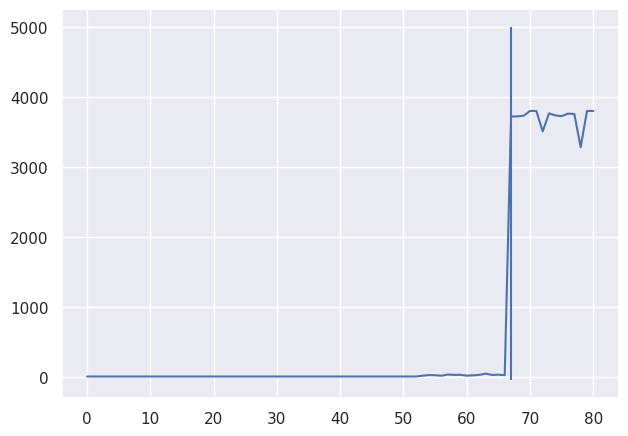

In [57]:
pd.DataFrame(tree_ready.fit_transform(X)).nunique().plot()
plt.vlines(67,-50,5000)